# Data Challenge #2 - Pricing Test
Company XYZ sells a software for 39 dollars, and this company conducted a test where raised price of 59 dollars was shown to 33% of the users. The goal of this analysis is to determin whether the company should raise the price for all the users. <br>

In [1]:
# loading packages
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, ttest_ind_from_stats

## 1. Load the data
First, I will load the 'test_results' data, which is the user behavior test for increased price. 66% of the users were randomly selected for the old price at 39 while the rest was shown an increased price at $59. 

In [2]:
test_results = pd.read_csv('/home/ying/18B/Data-Challenge-2/test_results.csv')
#user_table = pd.read_csv('user_table.csv')

In [3]:
test_results.head()

,Unnamed: 0,user_id,timestamp,source,device,operative_system,test,price,converted
0,0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0
1,1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0
2,2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0
3,3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59.0,0
4,4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0


In [4]:
test_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 9 columns):
Unnamed: 0          316800 non-null int64
user_id             316800 non-null int64
timestamp           316466 non-null object
source              316488 non-null object
device              316800 non-null object
operative_system    296461 non-null object
test                316800 non-null int64
price               316800 non-null float64
converted           316800 non-null int64
dtypes: float64(1), int64(4), object(4)
memory usage: 21.8+ MB


## 2. Pre-processing
Pre-processing each variable
 The 'source', 'device' and 'operative_system' parameters will be examined and converted to catagorical variables.  <br> The information of the data shows that the variable 'operative_system' has about 20k missing values, which will be imputed.
<br> The 'timestamp' will be converted to timestamp format. <br> Check 'test' and 'price' are the same thing.

### timestamp
Problem of timestamp: in this timestamp format, time were counting from 1-60, and can't be recongnized by pandas which count time from 0-59 <br> 
Inhere, I will just the original time if can't convert

In [5]:
# convert timestamp to the datetime type
test_results["timestamp"] =pd.to_datetime(test_results['timestamp'], errors='ignore', ) #return nonvalid as original


In [6]:
df_timestamp = pd.to_datetime(test_results['timestamp'], errors='coerce' )
pd.DataFrame(df_timestamp).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 1 columns):
timestamp    305905 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 2.4 MB


In [7]:
test_results['timestamp'].loc[df_timestamp.isnull()]

54        2015-04-24 12:60:46
104       2015-04-24 11:60:20
121       2015-03-14 12:60:02
278       2015-04-04 02:23:60
282       2015-05-11 12:60:53
287       2015-04-26 11:60:44
330       2015-03-20 12:20:60
361       2015-04-10 07:42:60
383       2015-03-10 12:31:60
388       2815-04-11 11:23:54
422       2015-04-17 12:10:60
430       2015-05-22 04:59:60
470       2015-05-31 15:60:59
474       2015-04-02 07:60:10
515       2015-04-16 17:02:60
519       2015-05-08 10:55:60
520       2015-05-15 20:11:60
586                       NaN
615       2015-05-01 10:49:60
639       2015-04-23 12:60:59
659       2015-05-07 18:60:11
670       2015-03-08 16:17:60
673       2815-03-27 12:34:19
701       2015-04-27 12:60:39
716       2015-04-10 09:60:26
718       2015-04-19 11:07:60
732       2015-05-15 17:41:60
812       2015-03-29 07:27:60
842       2015-03-08 08:21:60
944       2015-04-03 18:60:05
                 ...         
315727    2015-05-02 14:25:60
315757    2015-05-01 12:60:09
315789    

### source
Converting variable 'source' to catagorical datatype. 

In [8]:
test_results["source"] = test_results["source"].astype('category')
test_results["source"].value_counts()

direct_traffic     60307
ads-google         59319
ads_facebook       53337
ads_other          29849
seo-google         23160
ads-bing           22851
seo_facebook       21185
friend_referral    20672
seo-other           9250
ads-yahoo           7573
seo-yahoo           6836
seo-bing            2149
Name: source, dtype: int64

### "device"

In [9]:
test_results["device"] = test_results["device"].astype('category')
test_results["device"].value_counts()

mobile    186471
web       130329
Name: device, dtype: int64

### "Operative_system"
Operative system is acutally related to device variable. For mobile device, OS has android and iOS. For web device, OS has windows, macOS and linux (linux doesn't have any representation here). The Operative system will be corrected according to the device type and imputed with the median operative_system under the device catagory.

In [10]:
test_results["operative_system"] = test_results["operative_system"].astype('category')
test_results["operative_system"].value_counts()

windows    100878
iOS         95352
android     74856
mac         25056
i0S           113
wnddows        98
anroid         79
apple          29
Name: operative_system, dtype: int64

In [11]:
# correcting for obvious ones
test_results["operative_system"].loc[test_results["operative_system"]=='wnddows']='windows'
test_results["operative_system"].loc[test_results["operative_system"]=='i0S']='iOS'
test_results["operative_system"].loc[test_results["operative_system"]=='anroid']='android'

In [12]:
# check where 'apple' belongs to
test_results['operative_system'].loc[test_results['device']=='web'].value_counts()

windows    100976
mac         25056
apple          29
wnddows         0
iOS             0
i0S             0
anroid          0
android         0
Name: operative_system, dtype: int64

In [13]:
test_results["operative_system"].loc[test_results["operative_system"]=='apple']='mac'

In [14]:
test_results["operative_system"] = test_results["operative_system"].astype('category')
test_results["operative_system"].value_counts()

windows    100976
iOS         95465
android     74935
mac         25085
wnddows         0
i0S             0
apple           0
anroid          0
Name: operative_system, dtype: int64

In [15]:
# Impute the missing device type with the median of device type, 'web'->'windows', 'mobile' -> 'iOS'
test_results['operative_system'].loc[(test_results["operative_system"].isnull()) & (test_results["device"]=='web')] = 'windows'
test_results['operative_system'].loc[(test_results["operative_system"].isnull()) & (test_results["device"]=='mobile')] = 'iOS'


### 'test' and 'price'
The description suggest that when test = 1, users were shown the price of 59, while test = 0, users were shown the price of 39. We will double check this if there's any mis-label. <br> <br>
Rows with nconsistent labeling between 'test' and 'price' will be dropped because it's not clear which variable is reliable

In [16]:
test_results['test'].value_counts()

0    202727
1    114073
Name: test, dtype: int64

In [17]:
test_results.index[(test_results["test"]==0) &(test_results["price"]==59)]

Int64Index([  8238,   8369,  11555,  12848,  14630,  15020,  15724,  17252,
             20623,  22979,
            ...
            305508, 307444, 308723, 310426, 312287, 312725, 313735, 314275,
            315529, 316663],
           dtype='int64', length=209)

In [18]:
test_results = test_results.drop(test_results.index[(test_results["test"]==0) &(test_results["price"]==59)]);
test_results =test_results.drop(test_results.index[(test_results["test"]==1) &(test_results["price"]==39)]);

In [19]:
len(test_results)

316437

### drop price that are not 39 or 59

In [20]:
test_results = test_results.drop(test_results.index[(test_results['price']!=39) & (test_results['price']!=59)])

In [21]:
len(test_results)

313363

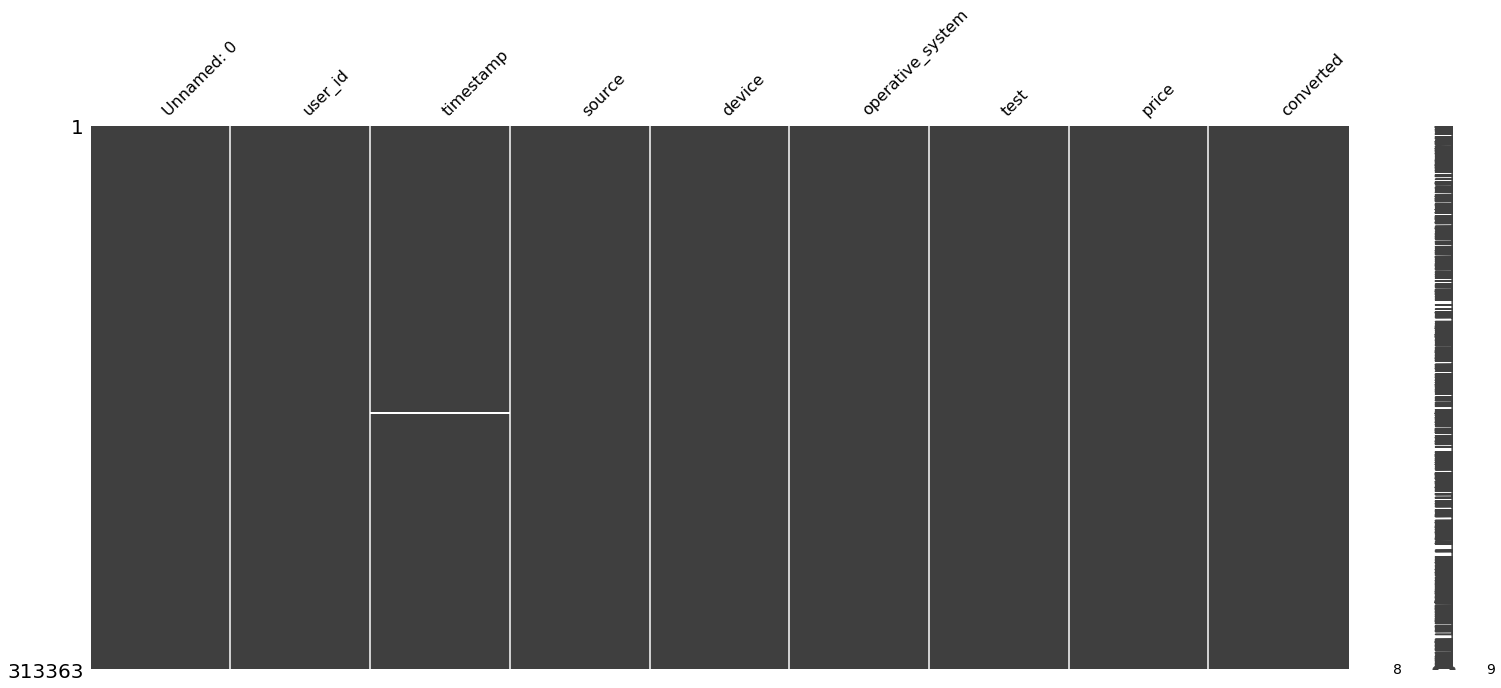

In [22]:
msno.matrix(test_results)

## 3. Feature engineering

### New feature: 'Profit'
This variable is the profit that made from user 

In [23]:
test_results['profit']= test_results['price'].astype(int)*test_results['converted'].astype(int)

## 4. Should the company sell its software at 39 or 59?


### Conversion Rate
Statistical t-test is performed to evaluate the conversion rate for two prices.

In [24]:
# conversion rate for lower price
p0 = sum((test_results["test"]==0) & (test_results["converted"]==1))/sum(test_results["test"]==0)
print('Conversion Rate with $39: '+ str(round(p0,4)))

Conversion Rate with $39: 0.0199


In [25]:
# conversion rate for higher price
p1 = sum((test_results["test"]==1) & (test_results["converted"]==1))/sum(test_results["test"]==1)
print('Conversion Rate with $59: '+ str(round(p1,4)))

Conversion Rate with $59: 0.0156


In [26]:
t, p = ttest_ind(test_results['converted'].loc[test_results["test"]==0], test_results['converted'].loc[test_results["test"]==1], equal_var=False)
print("t-test result:  t = %g  p = %g" % (t, p))


t-test result:  t = 8.97607  p = 2.82418e-19


 The results of t-test shows that the p-value is very small. This result can be interpreted as a significant change in the conversion rate (buying rate) due to the change in price. 


### Revenue
Decrease in conversion rate is expected when the price is raised. However, a more important aspect of the study is to evaluate the impact on revenue. 

In [27]:
E_p0 = sum(test_results['profit'].loc[test_results["test"]==0])/sum(test_results["test"]==0)
print('Expected income per user visit for $39 = ' + str(round(E_p0,3)))

Expected income per user visit for $39 = 0.776


In [28]:
E_p1 = sum(test_results['profit'].loc[test_results["test"]==1])/sum(test_results["test"]==1)
print('Expected income per user visit for $59 = ' + str(round(E_p1,3)))

Expected income per user visit for $59 = 0.918


In [29]:
t, p = ttest_ind(test_results['profit'].loc[test_results["test"]==0], test_results['converted'].loc[test_results["test"]==1], equal_var=False)
print("t-test result:  t = %g  p = %g" % (t, p))


t-test result:  t = 62.4878  p = 0


# Summary
### Even though the conversion rate has decreased with raised price, the company actually made more money from users with raised price. Therefore, the company should raise the price to 59 dollars according to this test.

## 5. Insights of user behavior -- incomplete

In [30]:
plt.hist(test_results.loc[(test_results['converted']==0)&(test_results['test']==j)].iloc[:,4])
plt.show()

NameError: name 'j' is not defined

In [ ]:
fig, ax = plt.subplots(2,2, figsize = (15,15))
for i in range(2):
    for j in range(2):
        ax[i,j].hist(test_results.loc[(test_results['converted']==0)&(test_results['test']==j)].iloc[:,5], alpha = 0.5)
        plt.hold(True)
        ax[i,j].hist(test_results.loc[(test_results['converted']==1)&(test_results['test']==j)].iloc[:,5], alpha = 0.5)
        ax[i,j].title.set_text(test_results.keys()[5])
plt.show()

In [32]:
test_results.head()

,Unnamed: 0,user_id,timestamp,source,device,operative_system,test,price,converted,profit
0,0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0,0
1,1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0,0
2,2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0,0
3,3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59.0,0,0
4,4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0,0


In [43]:
a = test_results['device'].value_counts()

In [47]:
a.keys()[0]

'mobile'

In [52]:
[test_results['device'].value_counts().keys(), test_results['test'].value_counts().keys()][:]

[CategoricalIndex(['mobile', 'web'], categories=['mobile', 'web'], ordered=False, dtype='category'),
 Int64Index([0, 1], dtype='int64')]

In [58]:
a =test_results.groupby(['device','test'])['converted'].mean()

In [67]:
a

device  test
mobile  0       0.019826
        1       0.016190
web     0       0.019974
        1       0.014681
Name: converted, dtype: float64

In [77]:
test_results[test_results['test']==0]

,Unnamed: 0,user_id,timestamp,source,device,operative_system,test,price,converted,profit
0,0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0,0
1,1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0,0
2,2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0,0
4,4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0,0
5,5,169971,2015-04-13 12:07:08,ads-google,mobile,iOS,0,39.0,0,0
6,6,600150,2015-03-04 14:45:44,seo_facebook,web,windows,0,39.0,0,0
10,10,590182,2015-04-17 13:30:04,ads-google,web,windows,0,39.0,0,0
11,11,606479,2015-05-15 12:36:46,direct_traffic,web,mac,0,39.0,0,0
12,12,425567,2015-04-24 10:09:04,ads_facebook,web,windows,0,39.0,0,0
13,13,460593,2015-03-21 09:43:51,friend_referral,mobile,iOS,0,39.0,1,39


Text(0,0.5,'Percentage of Conversion Rate')

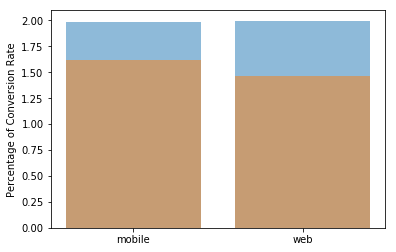

In [82]:
# conversion rate vs parameters
plt.bar(test_results['device'].value_counts().keys(), 100*test_results[test_results['test']==0].groupby(['device'])['converted'].mean(), alpha =0.5)
plt.bar(test_results['device'].value_counts().keys(), 100*test_results[test_results['test']==1].groupby(['device'])['converted'].mean(), alpha =0.5)
plt.ylabel('Percentage of Conversion Rate')